In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import fnmatch
import os
import pandas as pd
import datetime


In [11]:
def get_df(sdir, NAME, raw_x, TICKER ):
    '''
    This function iterates through RegSHO data over a data range and pulls rows for a TICKER and
    puts the data into a pandas data frame
    a row is as follows. The consolodated daily short data is in the CNMSyyyymmdd.txt file for every trade day
    
    Date|Symbol|ShortVolume|ShortExemptVolume|TotalVolume|Market
    
    '''
    xxx = []
    for shortdate in raw_x:
        #print(shortdate)
        for file in os.listdir(sdir):
            matchme = prefix+str(shortdate)+'*'
            if fnmatch.fnmatch(file, matchme):
                xxx.append(file)

    df = None            


    for filename in xxx:
        f = open(sdir+filename)
        try:
            fullfile = pd.read_csv(f,sep="|")
            if df is None:
                tickerrow = fullfile.loc[fullfile['Symbol'] == TICKER]
                df = tickerrow

            else:
                tickerrow = fullfile.loc[fullfile['Symbol'] == TICKER]
                df = df.append(tickerrow)
        except:
            print('failed: {}'.format(filename))
    return df

## Could the shorts actually have covered? 


        Data Source: http://regsho.finra.org/
        
The data under investigation is the daily RegSHO short report. This report details the reported short sales for each TICKER every trading day that has short interest. It covers B, N, & Q exhanges. FIXME: provide link for data breakdown and definitions 

The data can be downloaded using the python script at the end of this sheet. The Complete data set is about 500MB. It covers Jan 2018 to present on a daily basis. You are welcome to fully reproduce this study. 

CAVEATS: The RegSHO data for TOTAL VOLUME carries a warning that not all trades are covered, and intra broker trades are excluded and may yield issues. My guess is the larger ticker has all trades including brokers buying blocks and then divving them up to clients.  So the integrated tape double counts some trades.


Here we begin to examine if it was possible for the shorts to cover. 

The daily RegSHO data provides a consolidated data set in the files CNMSYYYYMMDD.txt 
It lists all *declared* short sales everyday for every TICKER sold short. Each entry follows this format

```Date|Symbol|ShortVolume|ShortExemptVolume|TotalVolume|Market```

The Monthly RegSHO data provides times & quantities for every short sale but is not examined here. 


------
The agorithm presented here:
1. Download the RegSHO daily data for as far back as possible on finra.org
    1. See last cell with pull.py 
1. Utilizing the CNMS short volume files
    1. Select a TICKER -- ***GME***
    1. Extract total ```short volume``` and ```total volume``` for each day
    1. Extract the dates in YYYYMMDD for each entry
    1. Convert date to Matplotlib friendly format
    1. Plot Raw values for **Short Volume** and **Total Volume**

1. Assumptions
    1. Data in RegSHO is correct
    1. No additional shares are injected into market -- ignoring 2 GME ATM offerings
    1. **Shorts** are ONLY sellers in the market
    1. **Long** positions are calculated with
        $$ \text{Long Position} = \text{Total Volume} - 2*\text{Short Volume} $$  
       
        ```A **short** sale requires both a buy and sell```


## Load up the data

We have to build the filename it follows the format

```CNSMshvolYYYYMMDD.txt```

In [12]:
# Generate dates to pull logs with
# We need to convert the Date time to YYYYMMDD as that is the format
# dates here are max values that are available. The earliest data I have is 20190102
x = pd.date_range(start='20210101',end='20220101',freq='D').strftime('%Y%m%d')

# this is the location of where I downloaded the data. REPLACE this with where you have your data 
sdir =  '/home/pookie/data/shortdata2/'

# Base Filename Generation
prefix = 'CNMSshvol'
#prefix = 'FNSQshvol'
# Our test Ticker.. 
TICKER = 'GME'

df = get_df(sdir, prefix, x, TICKER)
df.tail()
initial_short_position = 71200000

failed: CNMSshvol20210725.txt
failed: CNMSshvol20210731.txt
failed: CNMSshvol20210801.txt
failed: CNMSshvol20210807.txt
failed: CNMSshvol20210808.txt
failed: CNMSshvol20210814.txt
failed: CNMSshvol20210815.txt
failed: CNMSshvol20210821.txt
failed: CNMSshvol20210822.txt
failed: CNMSshvol20210828.txt
failed: CNMSshvol20210829.txt
failed: CNMSshvol20210904.txt
failed: CNMSshvol20210905.txt
failed: CNMSshvol20210906.txt
failed: CNMSshvol20210910.txt
failed: CNMSshvol20210911.txt
failed: CNMSshvol20210912.txt
failed: CNMSshvol20210913.txt
failed: CNMSshvol20210914.txt
failed: CNMSshvol20210915.txt
failed: CNMSshvol20210916.txt
failed: CNMSshvol20210917.txt
failed: CNMSshvol20210918.txt
failed: CNMSshvol20210919.txt
failed: CNMSshvol20210920.txt
failed: CNMSshvol20210921.txt
failed: CNMSshvol20210922.txt
failed: CNMSshvol20210923.txt
failed: CNMSshvol20210924.txt
failed: CNMSshvol20210925.txt
failed: CNMSshvol20210926.txt
failed: CNMSshvol20210927.txt
failed: CNMSshvol20210928.txt
failed: CN

Above is a sample of the end of the pandas dataframe holding the data under investigation

### Making Pretty Plots 
Change Data from YYYYMMDD to machine readable.

Naming convention:
    ``df`` stands for data frame in PANDAS
The ``df_`` prefix is used in the notebook to help me keep track

In [13]:
# Change the date format from YYYYMMDD to matplotlib compliant 
import datetime as dt
date_fmt ='%Y%m%d'

raw_x = df['Date']
df_dt = [dt.datetime.strptime(str(i), date_fmt) for i in raw_x]

# df_dt will be used throughout the file as the time series

# Introductory Plots

Text(0, 0.5, 'Millions of Shares')

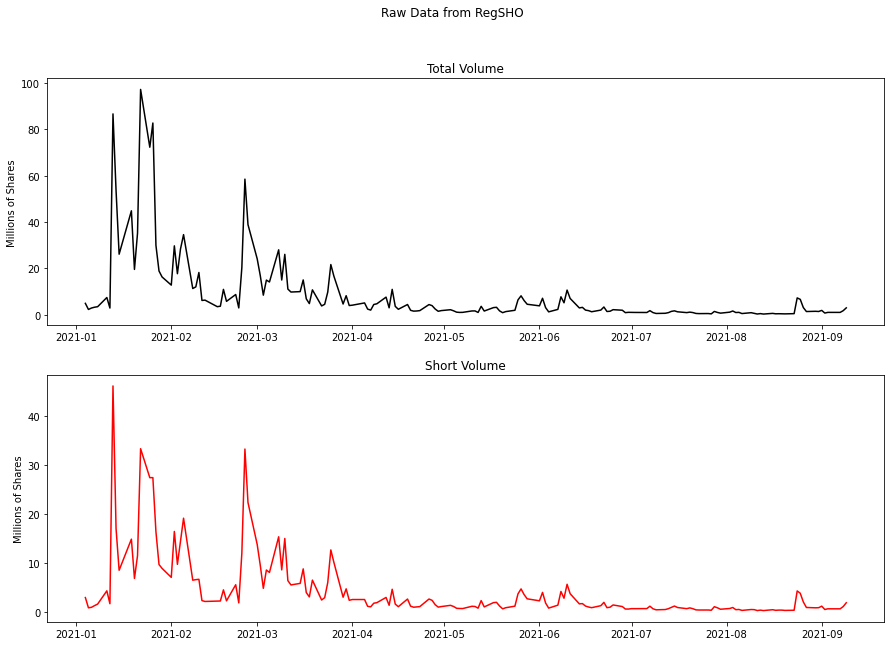

In [14]:
# Some example data to display

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Raw Data from RegSHO')

ax1.set_title('Total Volume')
ax2.set_title('Short Volume')

# Pull the total volume every day 
df_tv = df['TotalVolume']
ax1.plot(df_dt,df_tv/1e6,'k')
ax1.set_ylabel('Millions of Shares')

# Pull the short volume every day 
df_sv = df['ShortVolume']
ax2.plot(df_dt, df_sv/1e6,'r')
ax2.set_ylabel('Millions of Shares')

In [15]:
df_sv.head()

3561    2857152.0
3523     766709.0
3542     865047.0
3561    1214959.0
3567    1529124.0
Name: ShortVolume, dtype: float64

## Processed Data from RegSHO
 

### Percent or Short Sales every day:  
The plot shows $ \frac{\text{Short Volume}}{\text{Total Volume}} *100 $. It also has a horizontal line at 50% showing if the total sell side of shorts is more or less than 1/2 of the daily volume. 


Text(0.5, 0, 'Date')

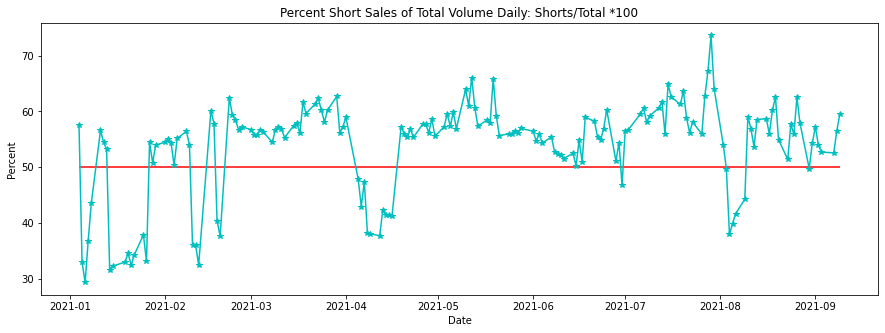

In [16]:
df_percent = df_sv/df_tv *100 
# We can also plot on a single canvas easily

plt.figure(figsize=(15,5))
plt.plot(df_dt,df_percent,'c-*')
plt.hlines(y=50, xmin=df_dt[0], xmax=df_dt[-1],color='r')

plt.title('Percent Short Sales of Total Volume Daily: Shorts/Total *100')
plt.ylabel('Percent')
plt.xlabel('Date')



## Create the Long Volume 


Text(0.5, 0, 'Date')

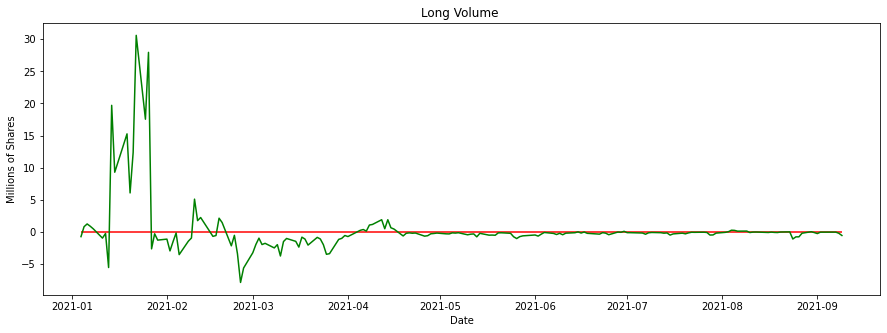

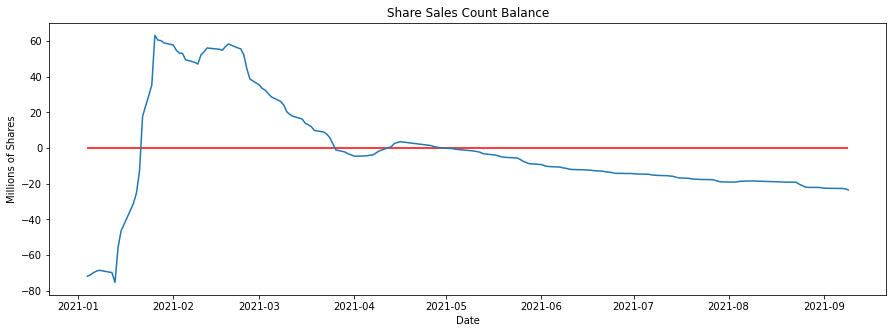

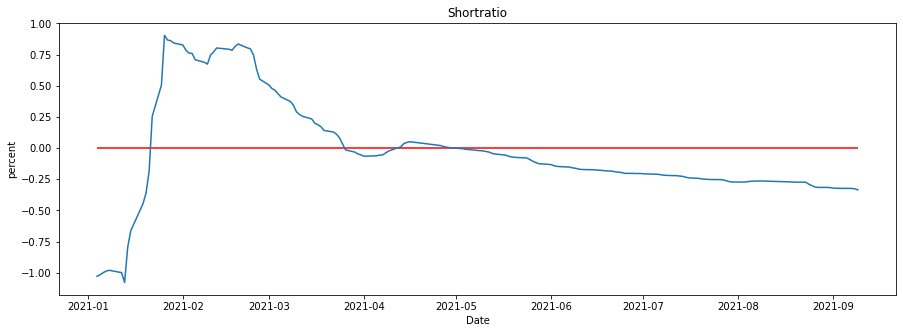

In [17]:
# long volume = Total Volume - 2 * short Volume accounting for intial transaction
df_lv = df_tv - 2*df_sv

plt.figure(figsize=(15,5))
plt.plot(df_dt,df_lv/1e6,'g')
plt.hlines(y=0, xmin=df_dt[0], xmax=df_dt[-1],color='r')

plt.title('Long Volume ')
plt.ylabel('Millions of Shares')
plt.xlabel('Date')

plt.figure(figsize=(15,5))
plt.hlines(y=0, xmin=df_dt[0], xmax=df_dt[-1],color='r')
plt.plot(df_dt,(np.cumsum(df_lv)/1e6)-initial_short_position/1e6)
plt.title('Share Sales Count Balance')
plt.ylabel('Millions of Shares')
plt.xlabel('Date')

short_ratio=((np.cumsum(df_lv)/1e6)-initial_short_position/1e6)/70
plt.figure(figsize=(15,5))
plt.hlines(y=0, xmin=df_dt[0], xmax=df_dt[-1],color='r')
plt.plot(df_dt,short_ratio)
plt.title('Shortratio')
plt.ylabel('percent')
plt.xlabel('Date')



## Suspect

Now that we see the % of short sales often is larger than the daily total volume **REPORTED** in **RegSHO**. Lets figure out if the shorts could have actually covered. 

# ASSUMPTIONS:

1. at t=0 there are NO SHORTS
1. Shorts are the only ones selling -- ignore GME Offerings
1. All shorts get dibs on buying any share back 

## Q: Could they have covered? 

# Cumulative *Shorts* vs *Long* buy

Text(0, 0.5, 'Millions of Shares')

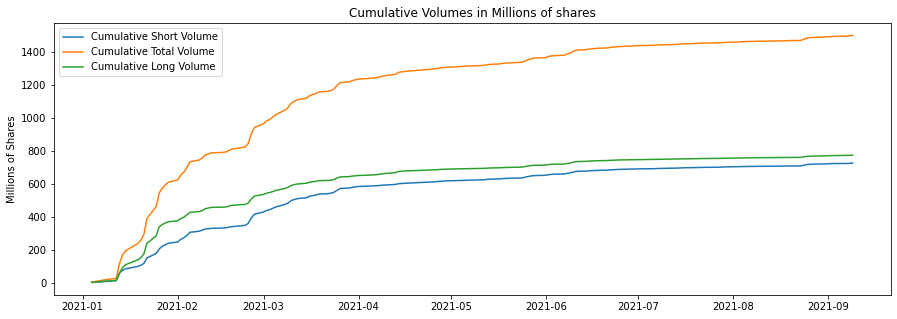

In [18]:
c_df_tv = np.cumsum(df_tv)
c_df_sv = np.cumsum(df_sv)
c_df_lv = np.cumsum(df_tv-df_sv)
plt.figure(figsize=(15,5))
plt.plot(df_dt,c_df_sv/1e6, label='Cumulative Short Volume')
plt.plot(df_dt,c_df_tv/1e6, label='Cumulative Total Volume')
plt.plot(df_dt,c_df_lv/1e6, label='Cumulative Long Volume')
plt.title('Cumulative Volumes in Millions of shares')
plt.legend()
plt.ylabel('Millions of Shares')

## It is hard to tell here what is going on. Lets change it up a bit. 

We are going to subtract the long buys minus the short sales. If the shorts covered the Short line shoud be above the zero line or near it. 

A negative number means that NOBODY could have sold this many MILLIONS shares back to the SHFs
 On July 2, 2021 --FINRA is showing about 9M shares shorted.


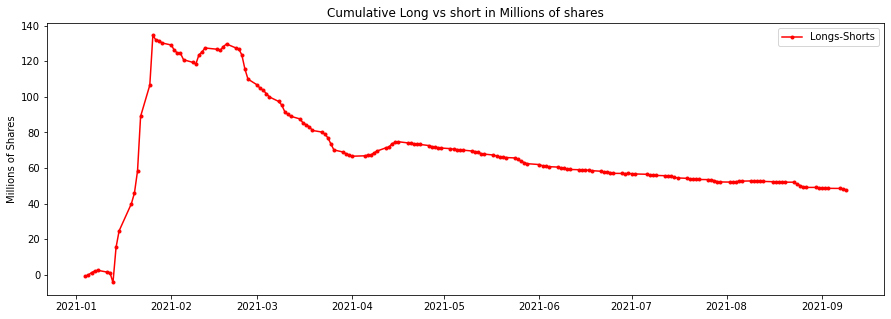

In [19]:
# Daily Difference between shorts and longs
dd = c_df_lv - c_df_sv
plt.figure(figsize=(15,5))
plt.plot(df_dt,dd/1e6, 'r.-',label='Longs-Shorts')
#plt.hlines(y=0, xmin=df_dt[0], xmax=df_dt[-1],color='g')
plt.title('Cumulative Long vs short in Millions of shares')
plt.ylabel('Millions of Shares')
plt.legend()
dd.tail()/1e6
print('A negative number means that NOBODY could have sold this many MILLIONS shares back to the SHFs')
print(' On July 2, 2021 --FINRA is showing about 9M shares shorted.')

## RegSHO

What can we see from this. 
1. On Jan 02, 2019 it is unlikely that there were no shorts on the market. 
1. If shorts covered during squeeze why are they digging a bigger hole? 
1. adding the two GME offerings makes this WORSE not better by the shares offered. 


## Unanswered questions

* What is the real Volume for the day. RegSHO or the integrated ticker. 
* The APES BUY & HODL is not in here. 
* DFV is not in here 
* RC buying is not in here. 




In [20]:
## Adding RC Investment
df.head()
derp = np.where(np.array(df_dt) > datetime.datetime(2021, 1, 10, 0, 0))
derp = derp[0]
derp[0]
df_lv.iloc[500:515]

Series([], dtype: float64)